# EDA of Chatbot Arena Dataset -- Starter Notebook

This notebook aims to help you explore the Chatbot Arena dataset, where two chatbots answer human questions, and users vote on the best response. Through this EDA, we will:
- Understand the dataset structure and contents.
- Explore the distribution of questions, responses, and chatbots.
- Identify patterns in the data to guide future modeling tasks.

## 1. Understanding the Dataset
The source dataset comes from https://huggingface.co/datasets/lmsys/chatbot_arena_conversations. The author describes the dataset as follows:

> This dataset contains 33K cleaned conversations with pairwise human preferences. It is collected from 13K unique IP addresses on the Chatbot Arena from April to June 2023. Each sample includes a question ID, two model names, their full conversation text in OpenAI API JSON format, the user vote, the anonymized user ID, the detected language tag, the OpenAI moderation API tag, the additional toxic tag, and the timestamp.

[Chatbot Arena](https://chat.lmsys.org/) is a platform where users can ask questions and two chatbots will provide answers. The user then votes on which chatbot provided the best answer. The dataset contains the questions, the answers, and the user votes.

### Main Dataset

- **Conversation Data**
You can find the processed dataset in `./chatbot-arena-conversations.jsonl.gz`. The dataset is in JSON line format and compressed using gzip. It has gone through the following preprocessing steps to make analysis easier:

    - Removed non-English conversations.
    - Removed conversations with more than one round.
    - Removed conversations classified as toxic or harmful.

The dataset you will be working with contains `25282` rows (out of `33000` total rows) and `7` columns. The columns are:

- `question_id`: A unique identifier for the question.
- `model_a`: The name of the first chatbot model.
- `model_b`: The name of the second chatbot model.
- `winner`: The name of the chatbot model that won the user vote.
- `judge`: The anonymized user ID that voted.
- `conversation_a`: The conversation between the user and `model_a`.
- `conversation_b`: The conversation between the user and `model_b`.

An example of the data is as follows:

```json
{
  "question_id": "c0fc42c6f5f14f2aa5a89f71f8553730",
  "model_a": "vicuna-13b",
  "model_b": "koala-13b",
  "winner": "model_a",
  "judge": "arena_user_973",
  "conversation_a": [
    {
      "content": "Count from 1 to 10 with step = 3",
      "role": "user"
    },
    {
      "content": "1, 4, 7, 10\n\nCounting with a step of 3 means that you will increase the number by 3 each time. So, the first number is 1, the next is 4 (1 + 3), the next is 7 (4 + 3), and so on.",
      "role": "assistant"
    }
  ],
  "conversation_b": [
    {
      "content": "Count from 1 to 10 with step = 3",
      "role": "user"
    },
    {
      "content": "1, 4, 7, 10",
      "role": "assistant"
    }
  ]
}
```

### Auxiliary Datasets

There are four auxiliary datasets that you can use to help with your analysis:

- **Embedding Data**
    - `./chatbot-arena-prompts-embeddings.npy` contains the 256-dimensional text embeddings for each of the human questions. The embeddings are generated using OpenAI’s text-embedding model. We will explain what embeddings are and how you can use them later.
    - `./chatbot-arena-model_a_response-embeddings.npy` contains the 256-dimensional text embeddings for each of the model a responses (second half of conversation a). The embeddings are generated using OpenAI’s text-embedding model. 
     - `./chatbot-arena-model_b_response-embeddings.npy` contains the 256-dimensional text embeddings for each of of the model b responses (second half of conversation b). The embeddings are generated using OpenAI’s text-embedding model.

- **Topic Modeling and Hardness Score Data**
- `./chatbot-arena-gpt3-scores.jsonl.gz` ([example row](https://gist.github.com/simon-mo/25c5d532bccc7f28b404cffdfe719e6e#file-example-aux-row-json))
 contains labels for the dataset, which you can use for later modeling tasks. It has the following fields:
  - **question_id**: The unique identifier for the question, as seen in `./chatbot-arena-conversations.jsonl.gz`.
  - **prompt**: The extracted human question. This is equivalent to the first message in `conversation_a` and `conversation_b` in `./chatbot-arena-conversations.jsonl.gz`.
  - **openai_scores_raw_choices_nested**: The response from OpenAI GPT 3.5 model. It contains:
    - The evaluated topic model
    - The reason for a hardness score (from 1 to 10)
    - The score value

  For each prompt, we have 3 responses from GPT 3.5 because it is a probabilistic model. In the real world, multiple annotators may provide different labels for ground truth data. We extracted the following fields into columns:

  - **topic_modeling_1, topic_modeling_2, topic_modeling_3**: Topic modeling for the first, second, and third response. Each topic contains two words.
  - **score_reason_1, score_reason_2, score_reason_3**: The reasons for the hardness score for the first, second, and third response.
  - **score_value_1, score_value_2, score_value_3**: The hardness score for the first, second, and third response.
 
```json
{
  "question_id": "58210e39b3fd4441a2bd4a518bb44c2d",
  "prompt": "What is the difference between OpenCL and CUDA?",
  "openai_scores_raw_choices_nested": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "{\n    \"topic_modeling\": \"Technical Comparison\",\n    \"score_reason\": \"This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI's factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them.\",\n    \"score_value\": 9\n}",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null
      }
    },
    {
      "finish_reason": "stop",
      "index": 1,
      "logprobs": null,
      "message": {
        "content": "{\n    \"topic_modeling\": \"Software Comparison\",\n    \"score_reason\": \"This prompt assesses the AI's factual accuracy in distinguishing between two similar but distinct software frameworks.\",\n    \"score_value\": 8\n}",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null
      }
    },
    {
      "finish_reason": "stop",
      "index": 2,
      "logprobs": null,
      "message": {
        "content": "{\n    \"topic_modeling\": \"Comparison, Technology\",\n    \"score_reason\": \"This prompt requires the AI to demonstrate knowledge of two different technologies, compare their features, and explain their distinctions. This task assesses the AI's factual accuracy and proficiency in understanding complex technological concepts.\",\n    \"score_value\": 9\n}",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null
      }
    }
  ],
  "topic_modeling_1": "Technical Comparison",
  "score_reason_1": "This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI's factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them.",
  "score_value_1": 9,
  "topic_modeling_2": "Software Comparison",
  "score_reason_2": "This prompt assesses the AI's factual accuracy in distinguishing between two similar but distinct software frameworks.",
  "score_value_2": 8,
  "topic_modeling_3": "Comparison, Technology",
  "score_reason_3": "This prompt requires the AI to demonstrate knowledge of two different technologies, compare their features, and explain their distinctions. This task assesses the AI's factual accuracy and proficiency in understanding complex technological concepts.",
  "score_value_3": 9
}
```

## 2. Loading the Data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [17]:
#Load all datasets
df = pd.read_json(
    "../data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)
df.head(5)
prompt_embeddings = np.load(
    "../data/training-set/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "../data/training-set/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "../data/training-set/chatbot-arena-model_b_response-embeddings.npy"
)

topic_and_hardness = pd.read_csv("../data/training-set/topic_hardness_embedding_cluster_labels.csv")

In [18]:
models = df["model_a"].unique()
print (models)

['chatglm-6b' 'oasst-pythia-12b' 'koala-13b' 'vicuna-13b'
 'stablelm-tuned-alpha-7b' 'alpaca-13b' 'llama-13b' 'dolly-v2-12b'
 'fastchat-t5-3b' 'gpt-3.5-turbo' 'gpt-4' 'claude-v1' 'RWKV-4-Raven-14B'
 'mpt-7b-chat' 'palm-2' 'claude-instant-v1' 'vicuna-7b' 'wizardlm-13b'
 'gpt4all-13b-snoozy' 'guanaco-33b']


## 3. Exploring the Data

### Converstation Data

Let's investigate the conversation data first (`chatbot-arena-conversations.jsonl.gz`). It is in JSON line format, compressed with `gzip`. You can load the data with `pd.read_json`.

Before diving into any analysis, it's important to understand the structure of the dataset. In this section, we'll check the basic details of the data, such as the number of rows, column names, data types, and any missing values.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25282 entries, 0 to 25281
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     25282 non-null  object
 1   model_a         25282 non-null  object
 2   model_b         25282 non-null  object
 3   winner          25282 non-null  object
 4   judge           25282 non-null  object
 5   conversation_a  25282 non-null  object
 6   conversation_b  25282 non-null  object
dtypes: object(7)
memory usage: 1.5+ MB


In [20]:
df.isnull().sum()

question_id       0
model_a           0
model_b           0
winner            0
judge             0
conversation_a    0
conversation_b    0
dtype: int64

As an example to guide you through the exploratory process, let’s investigate the length distribution of the prompt. This helps answer questions like (this is related to the ``Distribution of the prompt and response length'' requirement of the EDA assingment).
: 

- Do the arena users ask long or short questions?
- What is the average length of prompts that users give to the chatbots?

By analyzing the length of the prompts, you can start forming hypotheses about how the length might affect model performance or user votes. This example will guide you in asking similar questions about other aspects of the dataset.

In [21]:
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt"].head(1)

0    What is the difference between OpenCL and CUDA?
Name: prompt, dtype: object

In [22]:
df["prompt_length"] = df["prompt"].str.len()
df["prompt_length"].describe()

count    25282.00000
mean       196.74646
std        369.05595
min         16.00000
25%         42.00000
50%         72.00000
75%        156.00000
max       2560.00000
Name: prompt_length, dtype: float64

Looks like the mean length of the prompt is about **200 characters, while the median is 72 characters**. This suggests that the distribution is **right-skewed!** Let's visualize this.

<Axes: xlabel='prompt_length', ylabel='Count'>

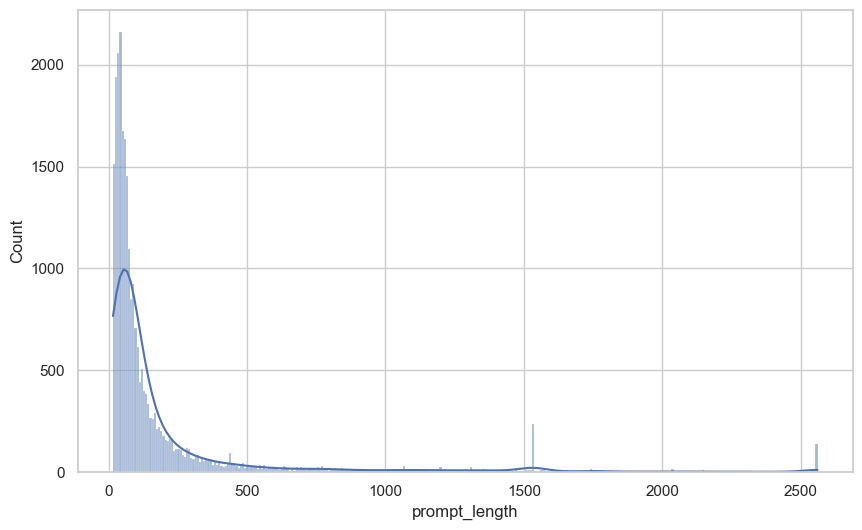

In [23]:
# Plot the distribution of the length of the prompt
plt.figure(figsize=(10, 6))
sns.histplot(df["prompt_length"], kde=True)

Now, can you apply the same thought process to visualize the distribution of the response length? 

Applying the same logic you used to make the `prompt` column, you should also make the columns `model_a_response` and `model_b_response` by extracting the **second half** of the content from `conversation_a` and `conversation_b` respectively in order to look into specific content of the model responses.

### Embedding Data

Text embedding models transform natural language text into numerical vectors. The vectors are generated in such a way that semantically similar text are close to each other in the vector space. In the real world, these embeddings to find similar questions or to cluster the questions.

Concretely, the auxiliary dataset,`./chatbot-arena-prompts-embeddings.npy`, `./chatbot-arena-model_a_response-embeddings.npy`, and `./chatbot-arena-model_b_response-embeddings.npy`, contains 256-dimensional text embeddings for each of the human questions, model a responses and model b responses respectively. 

In this section, we will walk you through an example of computing the similarity between prompts using the precomputed embeddings (`./chatbot-arena-prompts-embeddings.npy`). The goal is to find prompts that are most similar to a given prompt based on their embeddings.

Before we get started, let's first load and output the `propmt_embeddings` which we have loaded in the second section to see what they look like. Each embedding is a 256-dimensional vector that represents the semantic meaning of a prompt. These vectors allow us to compare prompts based on their content.

The embeddings are a matrix where each row corresponds to a prompt from the dataset. Each row is a 256-dimensional vector that captures the semantic meaning of the prompt.

In [24]:
prompt_embeddings.shape

(25282, 256)

The embeddings array has a shape of `(25282, 256)`, meaning there are 25,282 embeddings (one for each prompt), and each embedding is a 256-dimensional vector.

Next, we will:
1. Take a sample of the embeddings to reduce computation time.
2. Compute the dot product between the embeddings to measure similarity.
3. Retrieve the most similar prompts to a chosen source prompt.
4. Output the top 5 similar prompts.
(This is related to the ``(Open-ended) Explore the prompt topics in the dataset (topic modeling).'' requirement of the EDA assignment)

Start by taking a sample of the embeddings and calculating the similarity between them using the dot product.

In [25]:
# Let's try to find the closest prompt to a given prompt
embeddings_sample = prompt_embeddings[:1000]

# Compute the dot product between the embeddings
dot_product = np.dot(embeddings_sample, embeddings_sample.T)
dot_product.shape

(1000, 1000)

Given the above output, the dot product matrix has a shape of (1000, 1000), meaning we have similarity scores between all pairs of prompts in our sample of 1000.

Next, let's choose a prompt and find the top 5 most similar prompts based on the computed similarity.

In [26]:
source_prompt_idx = 23
source_prompt = df.iloc[source_prompt_idx].prompt
source_prompt

'Write me a function to lazily compute a Fibonacci sequence in Clojure. '

The prompt we're using as a reference (index 23) is:

`'Write me a function to lazily compute a Fibonacci sequence in Clojure.'`

Now let's find the top 5 most similar prompts to this one.

In [27]:
top_k = 5
similar_promts_idx = np.argsort(dot_product[source_prompt_idx])[-top_k:][::-1]
similar_promts = df.iloc[similar_promts_idx].prompt
similar_promts.tolist()

['Write me a function to lazily compute a Fibonacci sequence in Clojure. ',
 "Let's write a function that sums every third number from 1 to 100.",
 'Write an efficient Fibonacci number calculator in Python. ',
 'Write a program in Ocaml to compute the square root of a number.',
 'What is a pure function?']

As you can see, these prompts are closely related to programming tasks, many of them dealing with functions and computations. This shows how embeddings can group semantically similar questions together.

You also have the embeddings for responses from models a (`./chatbot-arena-model_a_response-embeddings.npy`) and model b (`./chatbot-arena-model_b_response-embeddings.npy`) respectively to explore. (These are the embeddings from columns `model_a_response` and `model_b_response` which can be created by extracting the second half of columns `conversation_a` and `conversation_b` respectively (as explained in the previous section).

Potential follow-up questions you can explore: 
- Can you identify clusters of similar topics within the dataset?
- How do different models perform on similar prompts?
- Can you find examples where semantically similar prompts result in different outcomes?

### Topic Modeling and Hardness Score Data

Now, let's explore the second auxiliary dataset `./chatbot-arena-gpt3-scores.jsonl.gz`, which contains valuable information for later modeling tasks. 

For each prompt, there are 3 responses, as GPT-3.5 is probabilistic. This means we get multiple labels for a single prompt, similar to how real-world datasets can have multiple annotations.

Let's start by loading and inspecting the first 5 rows of this dataset to understand its structure.

**_Warning_: This data can be messy! This is intentionally not cleaned up for you to resemble real-world data. You are responsible for figuring out the irregularities and cleaning it up. The following cells demonstrate the example of messy data.**

In [28]:
topic_and_hardness.head(5)

,Unnamed: 0,question_id,prompt,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3,prompt_objective,objective_term,prompt_topic,topic_term,Agglo_Cluster,HDBSCAN_Cluster
0,0,58210e39b3fd4441a2bd4a518bb44c2d,What is the difference between OpenCL and CUDA?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",technical comparison,This prompt requires the AI to accurately comp...,9,software comparison,This prompt assesses the AI's factual accuracy...,8,"comparison, technology",This prompt requires the AI to demonstrate kno...,9,comparing,comparison,programming,software,1,169
1,1,2564acd09e3942fd97657d05282d4389,Why did my parent not invite me to their wedding?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...","reasoning, emotion",This prompt requires the AI to understand huma...,9,"emotions, relationships",This prompt involves understanding complex hum...,8,"reasoning, emotional",This prompt challenges the AI to infer motives...,8,comparing,relation,Social,emotion,6,-1
2,2,90bfd142157948aba01931726c888e7f,"Fuji vs. Nikon, which is better?","[{'finish_reason': 'stop', 'index': 0, 'logpro...",camera comparison,This prompt does not require problem-solving s...,2,comparative analysis,This prompt assesses the AI's ability to analy...,6,photography comparison,This prompt is subjective and does not provide...,2,comparing,comparison,technology,photography,18,131
3,3,a7c5accc53e649a3bc6b2e41d962ebc4,How to build an arena for chatbots?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",chatbot arena,This prompt requires problem-solving skills an...,8,chatbot arena,This prompt requires the AI to engage in probl...,8,chatbot arena,This prompt requires problem-solving skills an...,8,NaN,NaN,AI,chatbot,30,190
4,4,adf27e819a3c494cb6e993f0c660e097,When is it today?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",time query,This prompt is very straightforward and does n...,2,date inquiry,This prompt is very straightforward and does n...,2,time-based inquiry,This prompt is too straightforward and simply ...,2,NaN,NaN,NaN,NaN,14,69


**Understand the Structure**
How are the topic modeling and hardness scores structured across the dataset?
- Look at the columns `topic_modeling_1`, `score_reason_1`, `score_value_1`, etc.
- How consistent are the values across the rows? Do they follow a pattern? Are there any irregularities or unexpected values?

**Data Cleaning**
The following are some of the things (many) you should explore to clean your data:
- Are there any missing values?
- The data in the `openai_scores_raw_choices_nested` field appears messy. It contains a list of nested dictionaries that might need to be flattened for easier analysis. Consider these points:
    - Do you need all the nested data? Perhaps you only need the final hardness scores and topic modeling results for your analysis.
    - One way to deal with the nested openai_scores_raw_choices_nested field is to flatten it into more readable columns if you find you need the nested data.
- Sometimes, there could be repeated entries in the dataset. Make sure that each question (question_id) and its corresponding responses are unique.

Let’s begin by checking for missing values in our dataset.

In [29]:
topic_and_hardness.isnull().sum()

Unnamed: 0                              0
question_id                             0
prompt                                  0
openai_scores_raw_choices_nested        0
topic_modeling_1                       29
score_reason_1                         26
score_value_1                          26
topic_modeling_2                       28
score_reason_2                         26
score_value_2                          26
topic_modeling_3                       27
score_reason_3                         26
score_value_3                          26
prompt_objective                     9346
objective_term                       9346
prompt_topic                        13090
topic_term                          13090
Agglo_Cluster                           0
HDBSCAN_Cluster                         0
dtype: int64

What are some strategies for handling missing values?

Messy data is not only about missing values, it can also be about inconsistent formatting. Let's check for inconsistencies in the `score_value_1` column of the dataset. The `score_value_1` field should contain numerical values representing hardness scores. However, sometimes data can be messy, and we might encounter values that are not in the expected format (e.g., lists instead of single numbers).

The code below demonstrates how to identify rows where `score_value_1` is incorrectly formatted as a list:

In [30]:
topic_and_hardness["score_value_1"][
    topic_and_hardness["score_value_1"].apply(lambda x: isinstance(x, list))
].head()

Series([], Name: score_value_1, dtype: object)

Why do you think `score_value_1` contains lists instead of single values? What might have caused this? What steps would you take to fix this issue so that `score_value_1` contains only numeric values? Are there any other columns that might have similar issues?

Once you clean the dataset, you can start your analysis by think about the following questions:
- Do models perform differently based on hardness scores?
- What are the most common topics in the dataset?
- Which topics tend to have higher hardness scores?

## Summary and Next Steps

You've now explored various aspects of the dataset, including prompt lengths, response lengths, and embeddings, as well as handling messy data. As you proceed, it's important to remember the key **EDA requirements** for this milestone:

1. **Ranking of the model based on their win rate or ELO ratings**
2. **Distribution of the prompt and response length** 
4. **Hardness score distribution and its correlation with the models** 
5. **Open-ended: Visualize the "variance" in model performance**
6. **Open-ended: Explore the prompt topics in the dataset (topic modeling)**

### What Have You Discovered?

Now that you've completed the initial exploration through this notebook, think about the following:

- **Which insights surprised you?**  
- **What further questions would you ask based on the patterns you've seen?**  
- **Which analyses are still missing or could be extended?**

This notebook provides a foundation for your EDA, but the real insights will come from the questions you ask and the deeper analyses you conduct. Use this notebook as a starting point to explore relationships in the data that will help inform your understanding of chatbot performance. By formulating and answering your questions as a team, you'll gain a richer understanding of the dataset and get ready for the modeling tasks.